In [1]:

import os 
os.chdir("../")

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams as rc

import torch
# font manager
# add font by otf file
from matplotlib import font_manager as fm
fm.fontManager.addfont("./eval/fonts/Palatino Linotype/palatinolinotype_roman.ttf")




configs = {
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    # 'font.sans-serif': ['Microsoft YaHei', 'SimHei', 'Arial', 'Liberation Sans', 'sans-serif'],
    'font.sans-serif': ['Palatino Linotype', 'Microsoft YaHei', 'SimHei', 'Arial', 'Liberation Sans', 'sans-serif'],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'mathtext.fontset': "cm",
    # 'mathtext.cal':"asana math",
    "font.size": 18,
    # 'axes.labelsize': 'large',
    # 'axes.labelpad': 8.0,
    # 'xtick.major.pad': 9.0,
}
rc.update(configs)
# save_root = "./figures/"



In [2]:
model_dir = "/root/tf-logs/3d-1pits-baseline-modifiedmlp128_4-actTanh-epoch3800-not_asymmetrical/model-3800.pt"

import torch
import pf_pinn as pfp
from matplotlib import gridspec
net = pfp.PFPINN(
    in_dim=256, hidden_dim=128, out_dim=2, layers=4,
    symmetrical_forward=False
)
net.model.model.act = torch.nn.Tanh()

net.to(net.device)
net.load_state_dict(torch.load(model_dir))
net

PFPINN(
  (embedding): SpatialTemporalFourierEmbedding()
  (model): PFEncodedPINN(
    (model): ModifiedMLP(
      (gate_layer_1): Linear(in_features=256, out_features=128, bias=True)
      (gate_layer_2): Linear(in_features=256, out_features=128, bias=True)
      (hidden_layers): ModuleList(
        (0): Linear(in_features=256, out_features=128, bias=True)
        (1): Linear(in_features=128, out_features=128, bias=True)
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): Linear(in_features=128, out_features=128, bias=True)
      )
      (out_layer): Linear(in_features=128, out_features=2, bias=True)
      (act): Tanh()
    )
  )
)

/tmp/ipykernel_4215/2533131268.py:64: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(axes[0, 0].collections[0], cax=cbar_ax)


max diff = 3.710e-01
mean diff = 5.600e-03


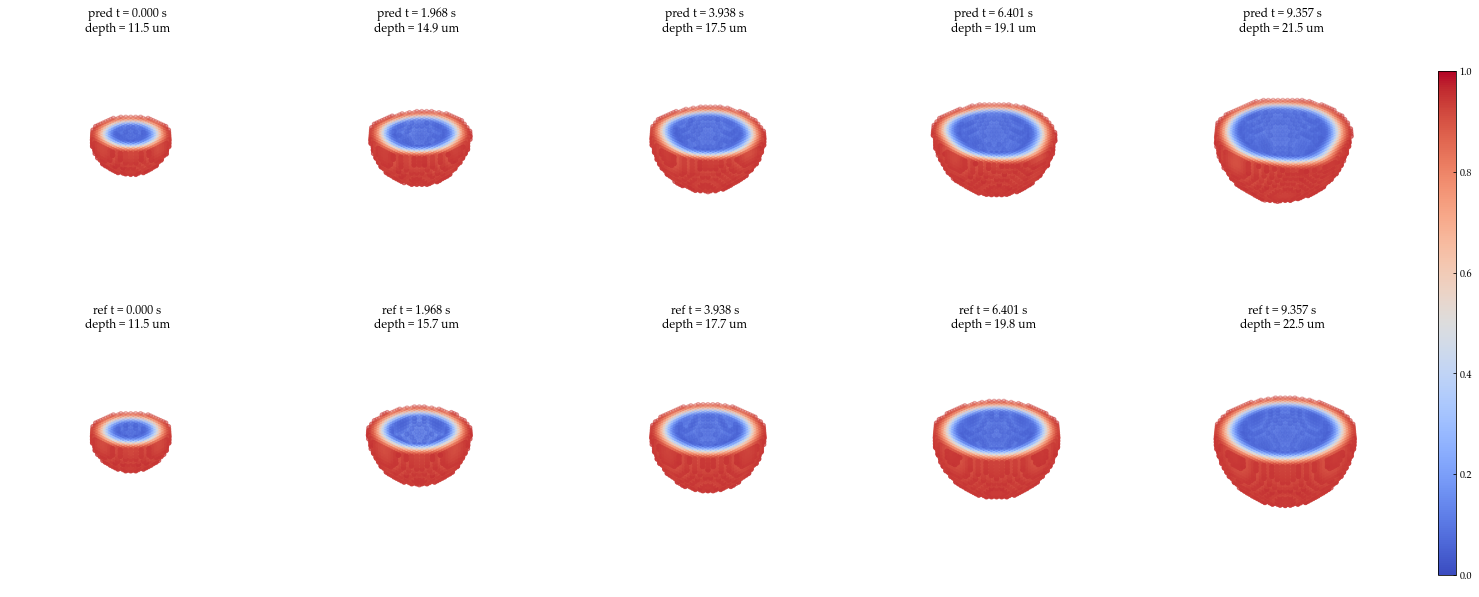

In [3]:
ts = [0.000, 1.968, 3.938, 6.401, 9.357]

mesh_points = np.load("./data/3d/mesh_points.npy") * 1e4
mse = 0

filter_ = np.where(
            (mesh_points[:, 0] >= -0.4) &
            (mesh_points[:, 0] <= 0.4) &
            (mesh_points[:, 1] >= -0.4) &
            (mesh_points[:, 1] <= 0.4) &
            (mesh_points[:, 2] >= 0) &
            (mesh_points[:, 2] <= 0.4)
        )[0]
mesh_points = mesh_points[filter_]

fig, axes = plt.subplots(2, len(ts), figsize=(5*len(ts), 10), 
                                 subplot_kw={"projection": "3d",
                                             "aspect": "auto",
                                             "box_aspect": (1, 1, 0.5),})
mesh_tensor = torch.from_numpy(mesh_points).float()
diffs = []
for idx, tic in enumerate(ts):
    tic_tensor = torch.ones(mesh_tensor.shape[0], 1)\
                .view(-1, 1) * tic * 1e-1
    geotime = torch.cat([mesh_tensor, tic_tensor], dim=1).to(net.device)
    with torch.no_grad():
        sol = net.net_u(geotime).detach().cpu().numpy()
        
    ax = axes[0, idx]
    idx_interface_sol = np.where((sol[:, 0] > 0.05) & (sol[:, 0] < 0.95))[0]
    ax.scatter(mesh_points[idx_interface_sol, 0], mesh_points[idx_interface_sol, 1],
                mesh_points[idx_interface_sol, 2], c=sol[idx_interface_sol, 0],
                cmap="coolwarm", label="phi", vmin=0, vmax=1)
    avg_depth = np.mean(
        (mesh_points[idx_interface_sol, 0]**2 \
        + mesh_points[idx_interface_sol, 1]**2 \
        + mesh_points[idx_interface_sol, 2]**2) ** 0.5
    )
    ax.set_title(f"pred t = {tic:.3f} s\ndepth = {avg_depth*100:.1f} um\n")
    ax.set_axis_off()
    ax.view_init(elev=30, azim=45)
    ax.set(xlim=(-0.3, 0.3), ylim=(-0.3, 0.3), zlim=(0.3, 0.))
    
    ax = axes[1, idx]
    truth = np.load("./data/3d/sol-" + f"{tic:.3f}" + ".npy")[filter_]
    diff = np.abs(sol[:, 0] - truth[:, 0])
    diffs.append(diff)
    idx_interface_truth = np.where((truth[:, 0] > 0.05) & (truth[:, 0] < 0.95))[0]
    ax.scatter(mesh_points[idx_interface_truth, 0], mesh_points[idx_interface_truth, 1],
                    mesh_points[idx_interface_truth, 2], c=truth[idx_interface_truth, 0],
                    cmap="coolwarm", label="phi", vmin=0, vmax=1)
    avg_depth = np.mean(
        (mesh_points[idx_interface_truth, 0]**2 \
        + mesh_points[idx_interface_truth, 1]**2 \
        + mesh_points[idx_interface_truth, 2]**2) ** 0.5
    )
    ax.set_title(f"ref t = {tic:.3f} s\ndepth = {avg_depth*100:.1f} um\n")
    ax.set_axis_off()
    ax.view_init(elev=30, azim=45)
    ax.set(xlim=(-0.3, 0.3), ylim=(-0.3, 0.3), zlim=(0.3, 0.))
    
# add colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
cbar = fig.colorbar(axes[0, 0].collections[0], cax=cbar_ax)

diffs = np.array(diffs)
print(f"max diff = {np.max(diffs):.3e}")
print(f"mean diff = {np.mean(diffs):.3e}")

/tmp/ipykernel_4215/3249921363.py:56: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(ax.collections[0], cax=ax_bar)
/tmp/ipykernel_4215/3249921363.py:81: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(ax.collections[0], cax=ax_bar)
/tmp/ipykernel_4215/3249921363.py:99: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(ax.collections[0], cax=ax_bar)


max diff = 3.709e-01
mean diff = 1.338e-02


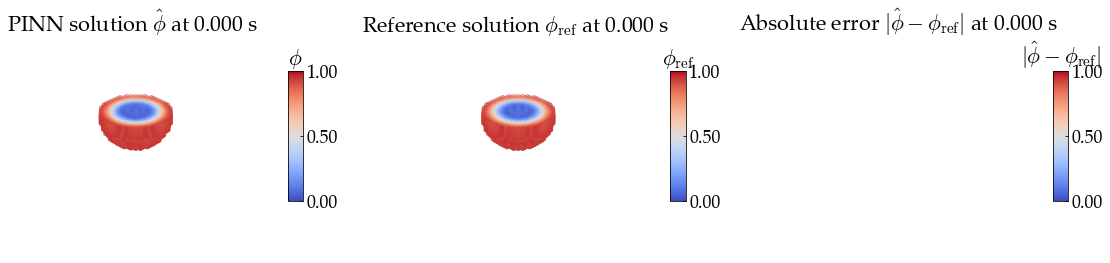

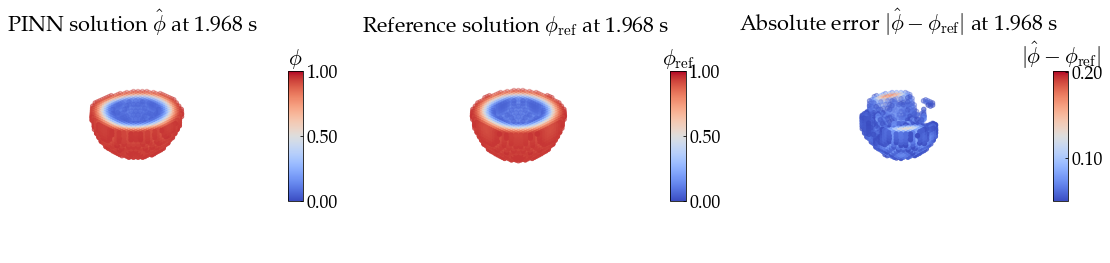

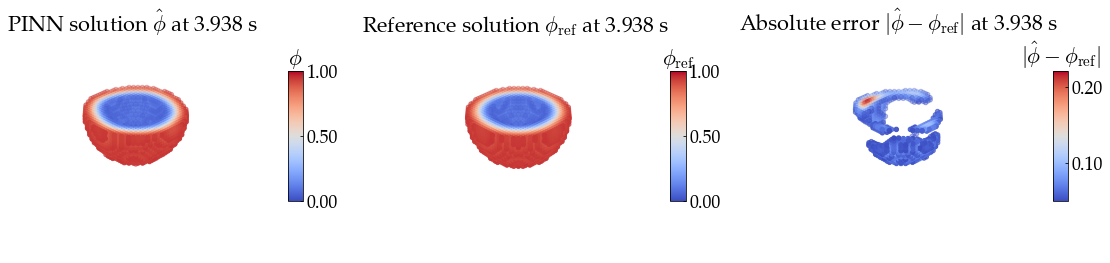

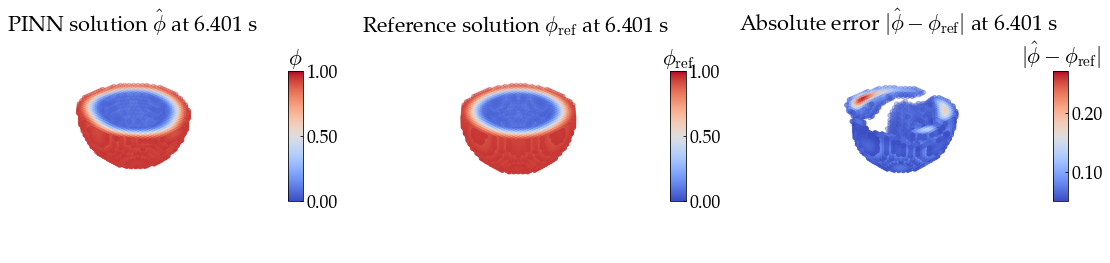

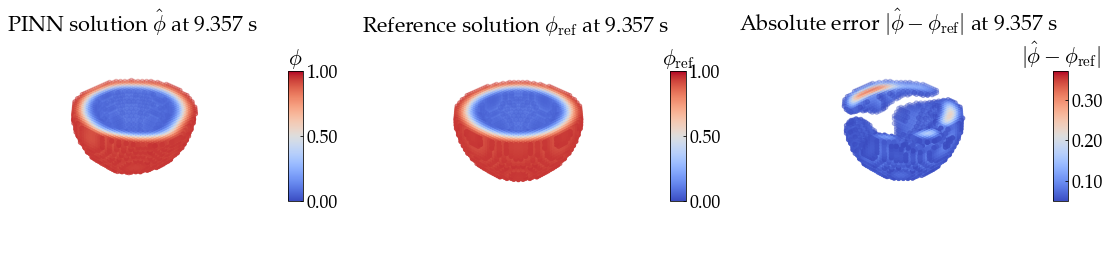

In [4]:
rc.update(configs)
ts = [0.000, 1.968, 3.938, 6.401, 9.357]

mesh_points = np.load("./data/3d/mesh_points.npy") * 1e4
mse = 0

filter_ = np.where(
            (mesh_points[:, 0] >= -0.3) &
            (mesh_points[:, 0] <= 0.3) &
            (mesh_points[:, 1] >= -0.3) &
            (mesh_points[:, 1] <= 0.3) &
            (mesh_points[:, 2] >= 0) &
            (mesh_points[:, 2] <= 0.3)
        )[0]
mesh_points = mesh_points[filter_]

subplot_kw = {"projection": "3d",
            "aspect": "auto",
            "box_aspect": (1, 1, 0.5),}
# fig, axes = plt.subplots(2, len(ts), figsize=(5*len(ts), 10), 
#                                  subplot_kw={"projection": "3d",
#                                              "aspect": "auto",
#                                              "box_aspect": (1, 1, 0.5),})
mesh_tensor = torch.from_numpy(mesh_points).float()
diffs = []
for idx, tic in enumerate(ts):
    
    fig = plt.figure(figsize=(20, 4))
    gs = gridspec.GridSpec(1, 6, width_ratios=[1, 0.05, 1, 0.05, 1, 0.05])
    
    
    tic_tensor = torch.ones(mesh_tensor.shape[0], 1)\
                .view(-1, 1) * tic * 1e-1
    geotime = torch.cat([mesh_tensor, tic_tensor], dim=1).to(net.device)
    with torch.no_grad():
        sol = net.net_u(geotime).detach().cpu().numpy()
        
    ax = fig.add_subplot(gs[0], **subplot_kw)
    idx_interface_sol = np.where((sol[:, 0] > 0.05) & (sol[:, 0] < 0.95))[0]
    ax.scatter(mesh_points[idx_interface_sol, 0], mesh_points[idx_interface_sol, 1],
                mesh_points[idx_interface_sol, 2], c=sol[idx_interface_sol, 0],
                cmap="coolwarm", label="phi", vmin=0, vmax=1)
    avg_depth = np.mean(
        (mesh_points[idx_interface_sol, 0]**2 \
        + mesh_points[idx_interface_sol, 1]**2 \
        + mesh_points[idx_interface_sol, 2]**2) ** 0.5
    )
    ax.set_axis_off()
    ax.view_init(elev=30, azim=45)
    ax.set(xlim=(-0.3, 0.3), ylim=(-0.3, 0.3), zlim=(0.3, 0.),
           title=r"PINN solution $\hat\phi$" + " at "+ f"{tic:.3f} s")
    
    
    
    ax_bar = fig.add_subplot(gs[1])
    fig.colorbar(ax.collections[0], cax=ax_bar)
    ax_bar.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x:.2f}'))
    pos = ax_bar.get_position()
    ax_bar.set_position([pos.x0 - 0.02, pos.y0+pos.height*0.25, pos.width, pos.height*0.6])
    ax_bar.set_title(r"$\phi$", loc="center")
    
    ax = fig.add_subplot(gs[2], **subplot_kw)
    truth = np.load("./data/3d/sol-" + f"{tic:.3f}" + ".npy")[filter_]
    diff = np.abs(sol[:, 0] - truth[:, 0])
    diffs.append(diff)
    idx_interface_truth = np.where((truth[:, 0] > 0.05) & (truth[:, 0] < 0.95))[0]
    ax.scatter(mesh_points[idx_interface_truth, 0], mesh_points[idx_interface_truth, 1],
                    mesh_points[idx_interface_truth, 2], c=truth[idx_interface_truth, 0],
                    cmap="coolwarm", label="phi", vmin=0, vmax=1)
    avg_depth = np.mean(
        (mesh_points[idx_interface_truth, 0]**2 \
        + mesh_points[idx_interface_truth, 1]**2 \
        + mesh_points[idx_interface_truth, 2]**2) ** 0.5
    )
    ax.set_axis_off()
    ax.view_init(elev=30, azim=45)
    ax.set(xlim=(-0.3, 0.3), ylim=(-0.3, 0.3), zlim=(0.3, 0.),
           title=r"Reference solution $\phi_{\mathrm{ref}}$" + " at "+ f"{tic:.3f} s")
    
    ax_bar = fig.add_subplot(gs[3])
    fig.colorbar(ax.collections[0], cax=ax_bar)
    ax_bar.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x:.2f}'))
    pos = ax_bar.get_position()
    ax_bar.set_position([pos.x0 - 0.02, pos.y0+pos.height*0.25, pos.width, pos.height*0.6])
    ax_bar.set_title(r"$\phi_{\mathrm{ref}}$", loc="center")
    
    ax = fig.add_subplot(gs[4], **subplot_kw)
    diff = np.abs(sol[:, 0] - truth[:, 0])
    idx_interface_diff = np.where((diff > 0.05))[0]
    ax.scatter(mesh_points[idx_interface_diff, 0], mesh_points[idx_interface_diff, 1],
                    mesh_points[idx_interface_diff, 2], c=diff[idx_interface_diff],
                    cmap="coolwarm", label="phi",)
    ax.set_axis_off()
    ax.view_init(elev=30, azim=45)
    ax.set(xlim=(-0.3, 0.3), ylim=(-0.3, 0.3), zlim=(0.3, 0.),
           title=r"Absolute error $|\hat\phi - \phi_{\mathrm{ref}}|$" + " at "+ f"{tic:.3f} s" )
    
    ax_bar = fig.add_subplot(gs[5])
    fig.colorbar(ax.collections[0], cax=ax_bar)    
    ax_bar.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x:.2f}'))
    pos = ax_bar.get_position()
    ax_bar.set_position([pos.x0 - 0.02, pos.y0+pos.height*0.25, pos.width, pos.height*0.6])
    ax_bar.set_title(r"$|\hat\phi - \phi_{\mathrm{ref}}|$", loc="center")
    # plt.savefig("./figures/3d-1pits-phi-fields" + f"-{idx}" + ".png", dpi=300, bbox_inches="tight")
    
# # add colorbar
# cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
# cbar = fig.colorbar(axes[0, 0].collections[0], cax=cbar_ax)

diffs = np.array(diffs)
print(f"max diff = {np.max(diffs):.3e}")
print(f"mean diff = {np.mean(diffs):.3e}")


# img_names = [f"./figures/3d-1pits-phi-fields-{idx}.png" for idx in range(len(ts))]
# from PIL import Image
# import os
# # 裁切掉图片下半部分的白边
# for img_name in img_names:
#     im = Image.open(img_name)
#     w, h = im.size
#     im = im.crop((0, 0, w, h-200))
#     im.save(img_name)

In [5]:
def format_with_scitific(x, prefix="L^2\; \\mathrm{error} = "):
    # e.g. 1.234\times 10^{-3}
    x = f"{x:.3e}"
    x = x.split("e")
    return prefix + f"{x[0]}\\times 10^{{{int(x[1])}}}"

/tmp/ipykernel_4215/1086245172.py:100: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(ax.collections[0], cax=ax_bar)


max diff = 3.709e-01
mean diff = 1.229e-02


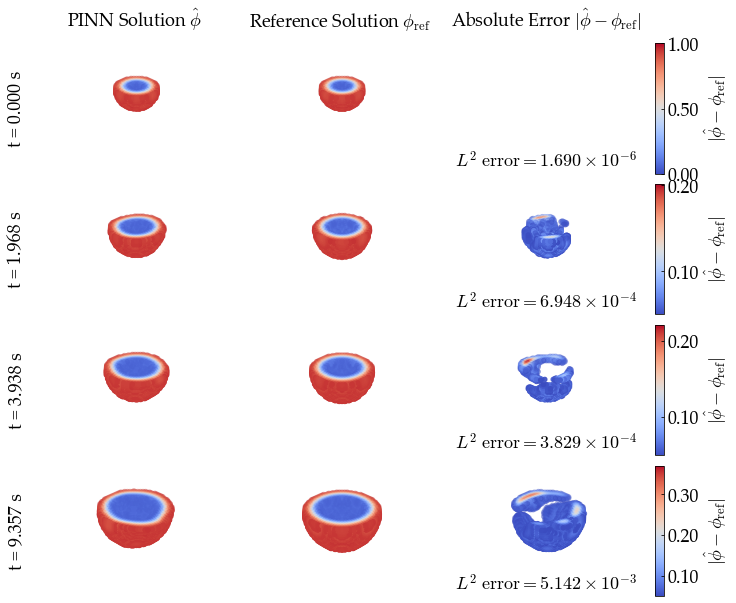

In [6]:
rc.update(configs)
ts = [0.000, 1.968, 3.938, 9.357]

mesh_points = np.load("./data/3d/mesh_points.npy") * 1e4
mse = 0

filter_ = np.where(
            (mesh_points[:, 0] >= -0.3) &
            (mesh_points[:, 0] <= 0.3) &
            (mesh_points[:, 1] >= -0.3) &
            (mesh_points[:, 1] <= 0.3) &
            (mesh_points[:, 2] >= 0) &
            (mesh_points[:, 2] <= 0.3)
        )[0]
mesh_points = mesh_points[filter_]

subplot_kw = {"projection": "3d",
            "box_aspect": (1, 1, 0.5),}
# fig, axes = plt.subplots(2, len(ts), figsize=(5*len(ts), 10), 
#                                  subplot_kw={"projection": "3d",
#                                              "aspect": "auto",
#                                              "box_aspect": (1, 1, 0.5),})

mesh_tensor = torch.from_numpy(mesh_points).float()
diffs = []

fig = plt.figure(figsize=(9, 2.*len(ts)))
gs = gridspec.GridSpec(len(ts)+1, 5, width_ratios=[0.05, 1, 1, 1, 0.05], height_ratios=[0.1, 1, 1, 1, 1],
                       top=1, bottom=0, left=0, right=1,)
col_names = [" ", "PINN Solution $\hat\phi$", "Reference Solution $\phi_{\mathrm{ref}}$", "Absolute Error $|\hat\phi - \phi_{\mathrm{ref}}|$"]
for idx, col_name in enumerate(col_names):
    ax = fig.add_subplot(gs[0, idx])
    ax.text(0.5, 0., col_name, fontsize=18,
            verticalalignment='bottom', horizontalalignment='center')
    ax.set_axis_off()
    
for idx, tic in enumerate(ts):
    
    ax = fig.add_subplot(gs[idx+1, 0])
    # text: t = 1.111s , fontsize=18, rotation=90
    ax.text(1.0, 0.5, f"t = {tic:.3f} s", fontsize=18, rotation=90, transform=ax.transAxes,
            verticalalignment='center', horizontalalignment='right')
    ax.set_axis_off()
    
    
    tic_tensor = torch.ones(mesh_tensor.shape[0], 1)\
                .view(-1, 1) * tic * 1e-1
    geotime = torch.cat([mesh_tensor, tic_tensor], dim=1).to(net.device)
    with torch.no_grad():
        sol = net.net_u(geotime).detach().cpu().numpy()
        
    ax = fig.add_subplot(gs[idx+1, 1], **subplot_kw)
    idx_interface_sol = np.where((sol[:, 0] > 0.05) & (sol[:, 0] < 0.95))[0]
    ax.scatter(mesh_points[idx_interface_sol, 0], mesh_points[idx_interface_sol, 1],
                mesh_points[idx_interface_sol, 2], c=sol[idx_interface_sol, 0],
                cmap="coolwarm", label="phi", vmin=0, vmax=1)
    avg_depth = np.mean(
        (mesh_points[idx_interface_sol, 0]**2 \
        + mesh_points[idx_interface_sol, 1]**2 \
        + mesh_points[idx_interface_sol, 2]**2) ** 0.5
    )
    ax.set_axis_off()
    ax.view_init(elev=30, azim=45)
    ax.set(xlim=(-0.3, 0.3), ylim=(-0.3, 0.3), zlim=(0.3, 0.),)
    
    ax = fig.add_subplot(gs[idx+1, 2], **subplot_kw)
    truth = np.load("./data/3d/sol-" + f"{tic:.3f}" + ".npy")[filter_]
    diff = np.abs(sol[:, 0] - truth[:, 0])
    diffs.append(diff)
    idx_interface_truth = np.where((truth[:, 0] > 0.05) & (truth[:, 0] < 0.95))[0]
    ax.scatter(mesh_points[idx_interface_truth, 0], mesh_points[idx_interface_truth, 1],
                    mesh_points[idx_interface_truth, 2], c=truth[idx_interface_truth, 0],
                    cmap="coolwarm", label="phi", vmin=0, vmax=1)
    avg_depth = np.mean(
        (mesh_points[idx_interface_truth, 0]**2 \
        + mesh_points[idx_interface_truth, 1]**2 \
        + mesh_points[idx_interface_truth, 2]**2) ** 0.5
    )
    ax.set_axis_off()
    ax.view_init(elev=30, azim=45)
    ax.set(xlim=(-0.3, 0.3), ylim=(-0.3, 0.3), zlim=(0.3, 0.),)
    
    
    ax = fig.add_subplot(gs[idx+1, 3], **subplot_kw)
    diff = np.abs(sol[:, 0] - truth[:, 0])
    idx_interface_diff = np.where((diff > 0.05))[0]
    ax.scatter(mesh_points[idx_interface_diff, 0], mesh_points[idx_interface_diff, 1],
                    mesh_points[idx_interface_diff, 2], c=diff[idx_interface_diff],
                    cmap="coolwarm", label="phi",)
    ax.set_axis_off()
    ax.view_init(elev=30, azim=45)
    ax.set(xlim=(-0.3, 0.3), ylim=(-0.3, 0.3), zlim=(0.3, 0.),)
    
    
    ax.text2D(0.5, 0.01, "$" + format_with_scitific(np.mean(diff**2)) + "$", 
              fontsize=18, verticalalignment='bottom', horizontalalignment='center', transform=ax.transAxes)
    
    
    ax_bar = fig.add_subplot(gs[idx+1, 4],)
    cbar = fig.colorbar(ax.collections[0], cax=ax_bar)    
    ax_bar.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x:.2f}'))
    cbar.set_label(r'$|\hat\phi - \phi_{\mathrm{ref}}|$')
    # pos = ax_bar.get_position()
    # ax_bar.set_position([pos.x0 - 0.02, pos.y0+pos.height*0.25, pos.width, pos.height*0.6])
    # ax_bar.set_title(r"$|\hat\phi - \phi_{\mathrm{ref}}|$", loc="center")
    
plt.subplots_adjust(wspace=0.1, hspace=0.1)  
# fig.tight_layout()
diffs = np.array(diffs)
print(f"max diff = {np.max(diffs):.3e}")
print(f"mean diff = {np.mean(diffs):.3e}")
# plt.savefig("./figures/3d-1pits-phi-fields.png", dpi=300, bbox_inches="tight")


In [20]:
def corrosion_ratio(data, thresh=0.05):
    return np.sum(data < thresh) / data.shape[0]

In [21]:
rc.update(configs)

ts = [0.000, 1.311, 1.968, 2.953, 3.938, 4.923, 6.401, 7.879, 9.357]
mesh_points = np.load("./data/3d/mesh_points.npy") * 1e4
corrosion_ratio_history = np.zeros((len(ts), 2))

for idx, tic in enumerate(ts):
    
    tic_tensor = torch.ones(mesh_points.shape[0], 1).view(-1, 1) * tic * 1e-1
    mesh_tensor = torch.from_numpy(mesh_points).float()
    geotime = torch.cat([mesh_tensor, tic_tensor], dim=1).to(net.device)
    with torch.no_grad():
        sol = net(geotime).cpu().detach().numpy()
        
    truth = np.load("./data/3d/sol-" + f"{tic:.3f}.npy")
    corrosion_ratio_history[idx, 0] = corrosion_ratio(sol[:, 0])
    corrosion_ratio_history[idx, 1] = corrosion_ratio(truth[:, 0])
    


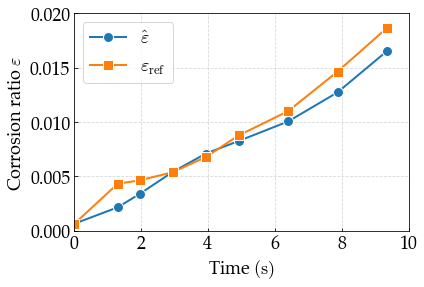

In [23]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(ts, corrosion_ratio_history[:, 0], label=r"$\hat\varepsilon$", 
        marker='o', markeredgecolor="white", markersize=10, lw=2,
        markeredgewidth=1)
ax.plot(ts, corrosion_ratio_history[:, 1], label=r"$\varepsilon_{\mathrm{ref}}$",
        marker='s', markeredgecolor="white", markersize=10, lw=2,
        markeredgewidth=1)
ax.set(xlim=(0, 10), ylim=(0, 0.02), xlabel="Time " + r"$\mathrm{(s)}$", 
       ylabel="Corrosion ratio " + r"$\varepsilon$")
ax.legend()
plt.savefig("figures/3d-1pit-corrosion-ratio.pdf", dpi=300, bbox_inches='tight')